In [23]:
from functools import partial
from itertools import product
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import SoilsDataset
from umap import UMAP


In [2]:
soils_data = SoilsDataset('data/soils')
tree = soils_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [3]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)

soil_mf = soils_data['metadata']
soil_table = soils_data['table']
metadata = soil_mf.set_index('sample_name')
soil_table = soil_table.filter(metadata.index)
table = min_count_filter.fit_transform(soil_table)
metadata = metadata.loc[table.ids('sample')]

In [4]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [5]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [6]:
prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': Pipeline([
            ('asdense', AsDense()),
            ('clr', CLR()),
        ]),
    },
    {
        'name': 'Bray-Curtis',
        'metric': 'braycurtis',
        'pipeline': AsDense(),
    },
    {
        'name': 'Jaccard',
        'metric': 'jaccard',
        'pipeline': AsDense(),
    },
    {
        'name': 'UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree),
    },
    {
        'name': 'Weighted UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree,
                            unifrac_method='weighted_unnormalized'
                            ),
    },
]

In [27]:
def UmapPCA(metric, min_dist=0.15, n_neighbors=15, random_state=None,
            n_components=2):
    return Pipeline([
        ('umap', UMAP(metric=metric,
                      min_dist=min_dist,
                      n_neighbors=n_neighbors,
                      n_components=n_components,
                      random_state=random_state,
                      )),
        ('pca', PCA()),
    ])

In [61]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(
            UmapPCA,
            min_dist=1.0,
            random_state=724,
            n_components=2,
        ),
        'postprocess': postprocess_umap,
    },
    {
        'method': 'UMAP\nNeighors=80',
        'pipeline': partial(
            UmapPCA,
            min_dist=1.0,
            n_neighbors=80,
            random_state=825,
            n_components=2,
        ),
        'postprocess': postprocess_umap,
    },
]

In [62]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    results[(name, method)] = {'ordination': result}


/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/s

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns


In [64]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}


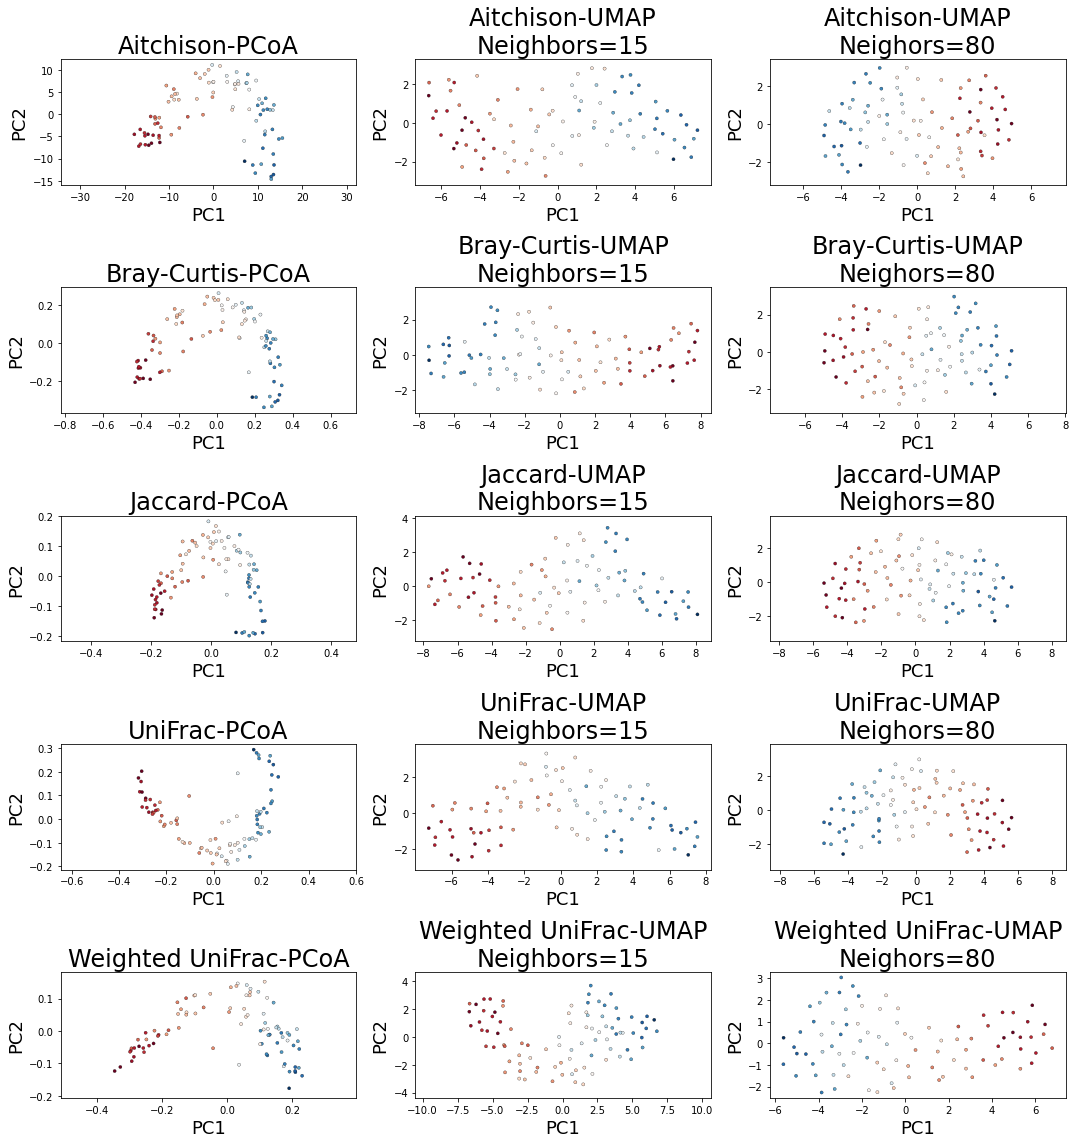

In [65]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 8 * 6 / 3),
                        )
hue_var = 'ph'
for name, method in results:
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue_var,
            data=res,
            ax=axs[i][j],
            s=10,
            edgecolor='k',
            palette='RdBu',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel('PC1', color='black', fontsize=18)
        g.set_ylabel('PC2', color='black', fontsize=18),

plt.tight_layout()
plt.savefig(f'results/2.0-real-data-soil-ordination-{hue_var}.png')
plt.show()


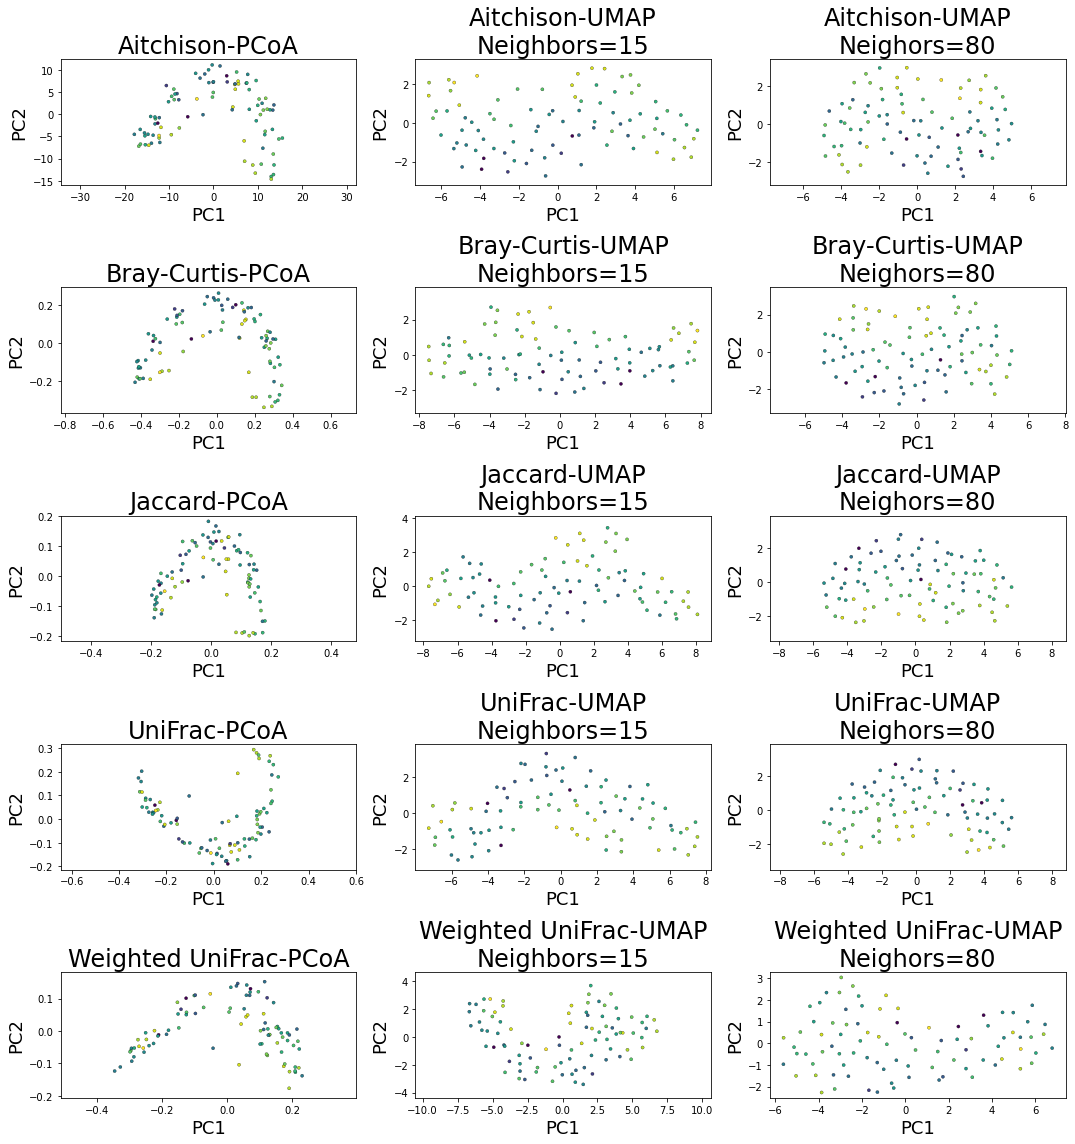

In [71]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 8 * 6 / 3),
                        )
hue_var = 'annual_season_temp'
for name, method in results:
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue_var,
            data=res,
            ax=axs[i][j],
            s=10,
            edgecolor='k',
            palette='viridis',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel('PC1', color='black', fontsize=18)
        g.set_ylabel('PC2', color='black', fontsize=18),

plt.tight_layout()
plt.savefig(f'results/2.0-real-data-soil-ordination-{hue_var}.png')
plt.show()

In [67]:

def get_numeric_index_matching(metadata, category, value):
    new_index = metadata[category].reset_index(drop=True)
    matches = new_index == value
    return new_index.index[matches]

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import CCA, PLSCanonical
from scipy.spatial.distance import cdist
import numpy as np


In [90]:
target_var = 'ph'
class mock_result:
    correlation = 0
all_correlations = []
for (name, method), result in results.items():
    target = metadata[target_var]

    first_component = result['ordination']['PC1']
    for category in metadata.columns:
        sr2 = spearmanr(target, first_component)
        all_correlations.append({
            'name': name,
            'PC': 1,
            'method': method,
            'category': category,
            'spearmanr': sr2.correlation,
        })

    second_component = result['ordination']['PC2']

    secondary_gradients = [None, mock_result()]
    for category in metadata.columns:
        secondary_target = metadata[category]
        sr2 = spearmanr(secondary_target, second_component)
        all_correlations.append({
            'name': name,
            'method': method,
            'PC': 2,
            'category': category,
            'spearmanr': sr2.correlation,
        })
        if abs(sr2.correlation) > abs(secondary_gradients[1].correlation):
            secondary_gradients = [category, sr2]

    # print(name, method, spearmanr(target, first_component))
    # print(name, method, secondary_gradients)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [89]:
pd.DataFrame(all_correlations).query(
    "name == 'Aitchison' and ((category == 'annual_season_temp' and PC == 2) "
    "or (category == 'ph' and PC == 1))"
).sort_values(by=['PC', 'category']).round(3)

,name,PC,method,category,spearmanr
16,Aitchison,1,PCoA,ph,0.934226
76,Aitchison,1,UMAP\nNeighbors=15,ph,0.935855
136,Aitchison,1,UMAP\nNeighors=80,ph,-0.930757
31,Aitchison,2,PCoA,annual_season_temp,-0.313518
91,Aitchison,2,UMAP\nNeighbors=15,annual_season_temp,0.599540
151,Aitchison,2,UMAP\nNeighors=80,annual_season_temp,0.473879


In [ ]:
target_var = 'ph'

for (name, method), result in results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]

    target = metadata[target_var]

#     distances = cdist(first_pcs.iloc[1:, :], first_pcs.iloc[[0], :])
#     # do  linear regression
#     sub_ph = target.iloc[1:]
#     g = sns.scatterplot(
#         x=sub_ph,
#         y=distances.flatten(),
#         hue=sub_ph,
#         palette='RdBu',
#     )
#     g.set_title(name + method)
#     plt.show()

    model = PLSCanonical(n_components=1)
#     model = LinearRegression()
    model.fit(first_pcs, target)
    residuals = target - model.predict(first_pcs)
    # print(target.shape, model.y_loadings_, model.x_loadings_.shape)
    X = model.transform(first_pcs)
    pred_pcs = model.inverse_transform(X)
    norms = ((first_pcs - pred_pcs) ** 2).sum(axis=1)
    g = sns.scatterplot(
        x=target,
        y=norms,
        hue=target,
        palette='RdBu',
    )
    g.set_title(name + method)
    g.set_aspect('equal')
    plt.show()
    stats_result = {
        'R2': model.score(first_pcs, target),
        # 'residuals': residuals,
    }

    result[result_key] = {'linear': stats_result,
    #                       'nonlinear': nonlinear_result,
                          }


In [150]:
for (name, method), result in results.items():
    result['test statistics'] = dict()
    result['test statistics']['Linear $R^2$'] = \
        result['sample_gradient_test']['linear']['R2']
    # result['test statistics']['Non-Linear $R^2$'] = \
    #     result['sample_gradient_test']['nonlinear']['R2']


In [151]:
test_statistics = dict()
for (name, method), result in results.items():
    test_statistics[(name, method)] = result['test statistics']

In [152]:
pd.DataFrame(test_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
}, axis=1).T.round(3)

Linear $R^2$
Aitchison        PCoA                      0.864
                 UMAP Neighbors=15         0.858
                 UMAP\nNeighors=80         0.866
Bray-Curtis      PCoA                      0.866
                 UMAP Neighbors=15         0.850
                 UMAP\nNeighors=80         0.890
Jaccard          PCoA                      0.884
                 UMAP Neighbors=15         0.867
                 UMAP\nNeighors=80         0.891
UniFrac          PCoA                      0.908
                 UMAP Neighbors=15         0.859
                 UMAP\nNeighors=80         0.877
Weighted UniFrac PCoA                      0.850
                 UMAP Neighbors=15         0.817
                 UMAP\nNeighors=80         0.834